In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3c
commitnumber = a22ab94
conc = 0.0008
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 257
vmax = 800
vmin = 720
w_diffuse = [(1.7, 1.6, 1.8), (1.8, 1.7), (1.5, 1.6, 1.7, 1.8)]
wgt = [(0.6, 0.4, 0.7), (0.7, 0.4), (0.3, 0.4, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

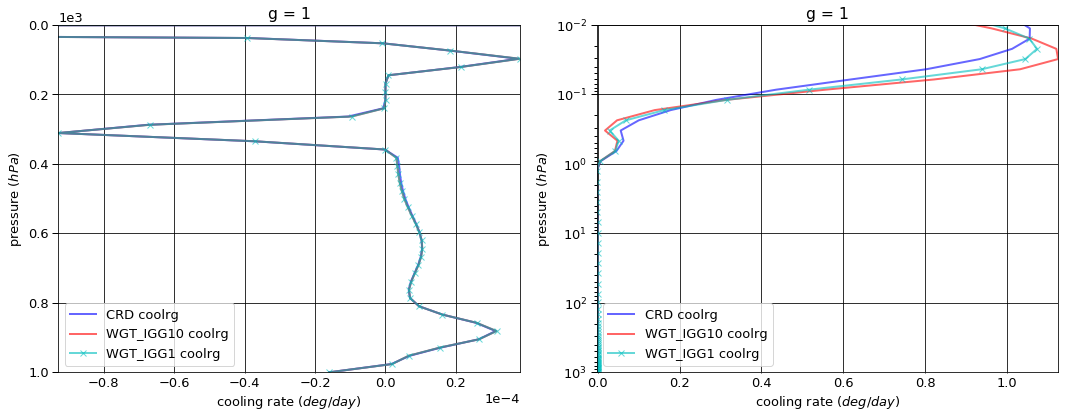

# Figure: cooling rate g-group 2

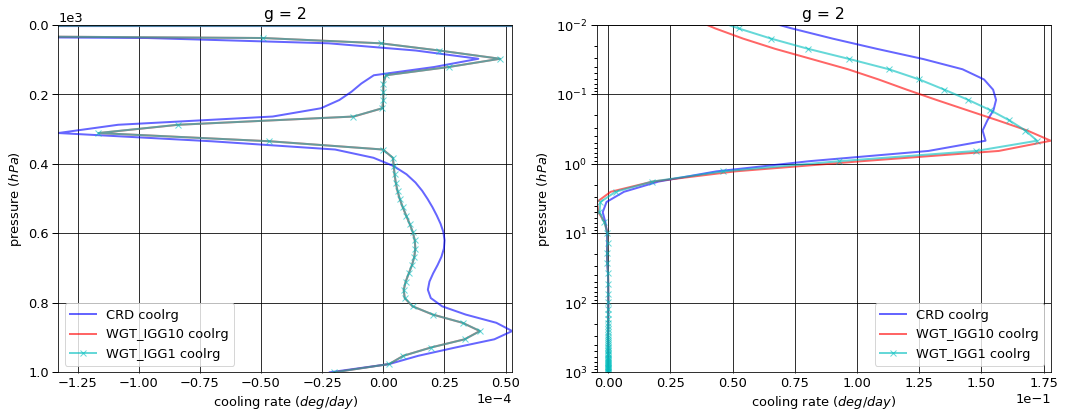

# Figure: cooling rate g-group 3

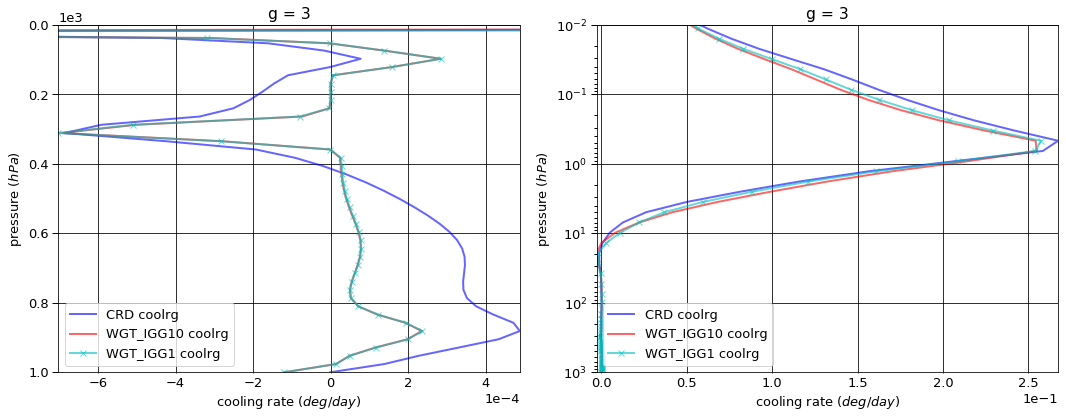

# Figure: cooling rate g-group 4

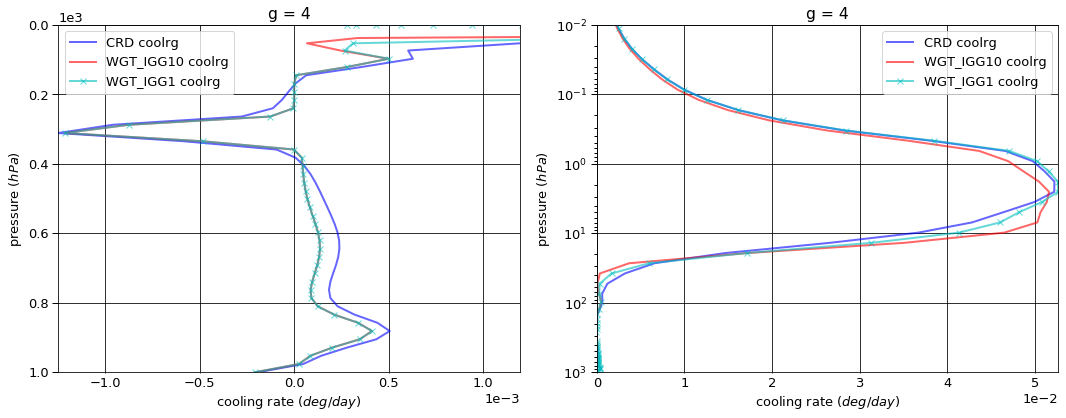

# Figure: cooling rate g-group 5

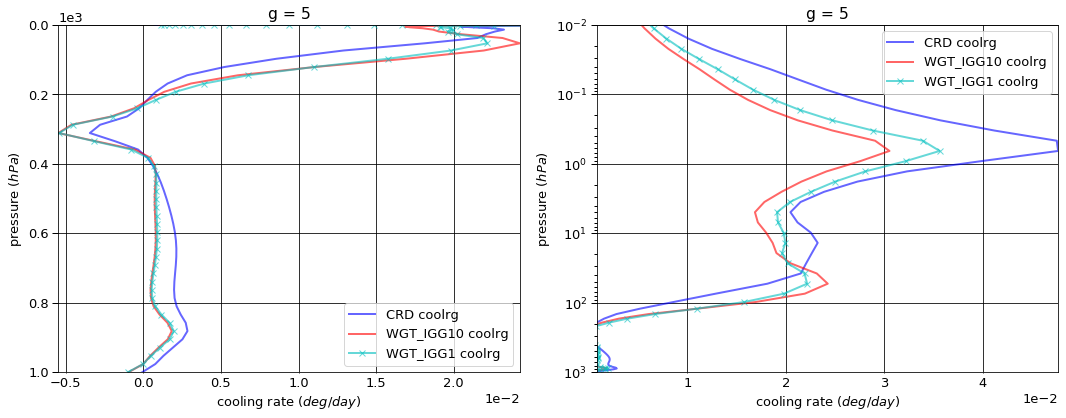

# Figure: cooling rate g-group 6

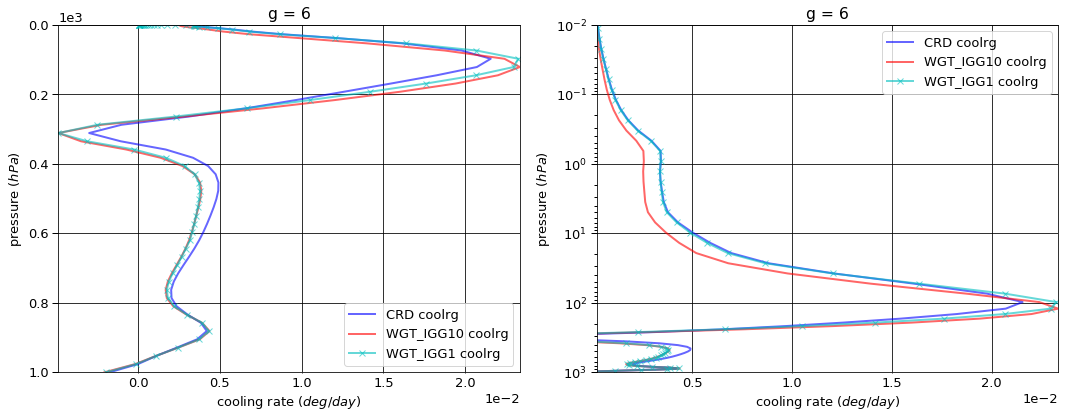

# Figure: cooling rate g-group 7

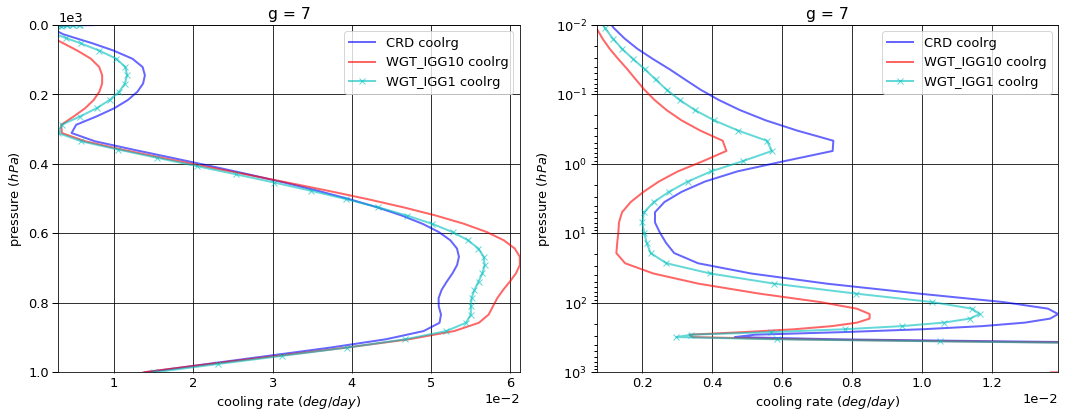

# Figure: cooling rate g-group 8

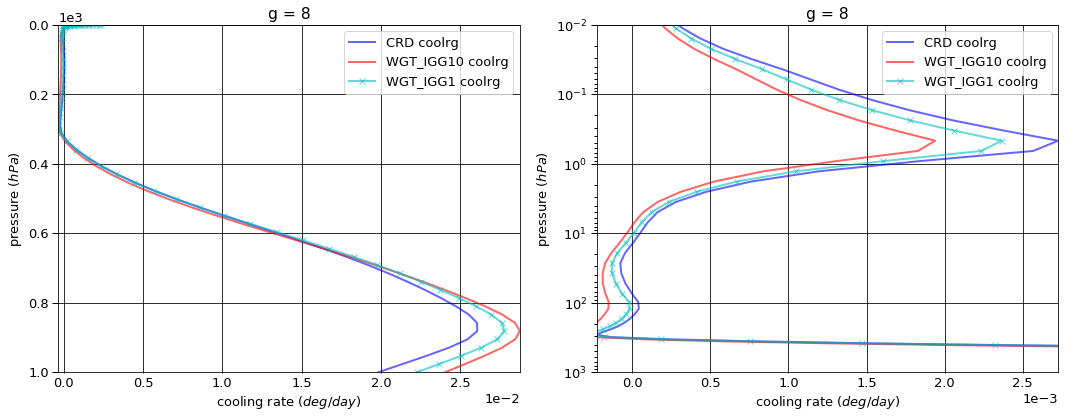

# Figure: cooling rate g-group 9

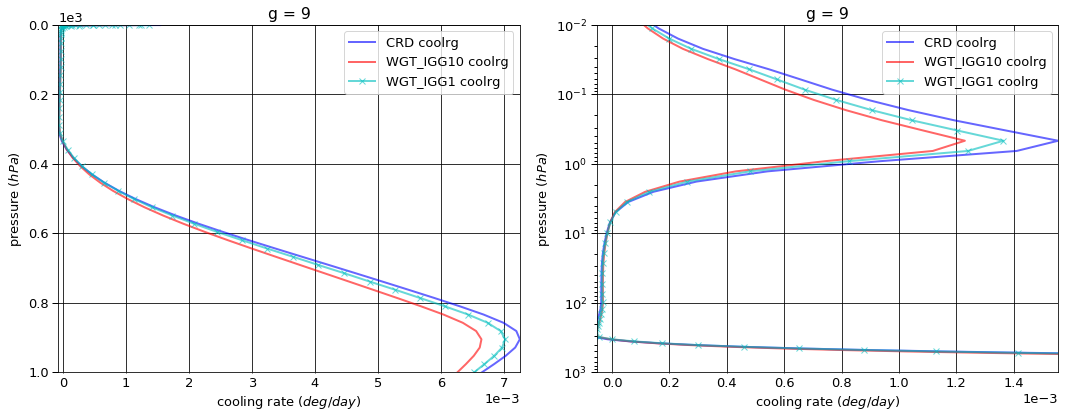

# Figure: cooling rate g-group total

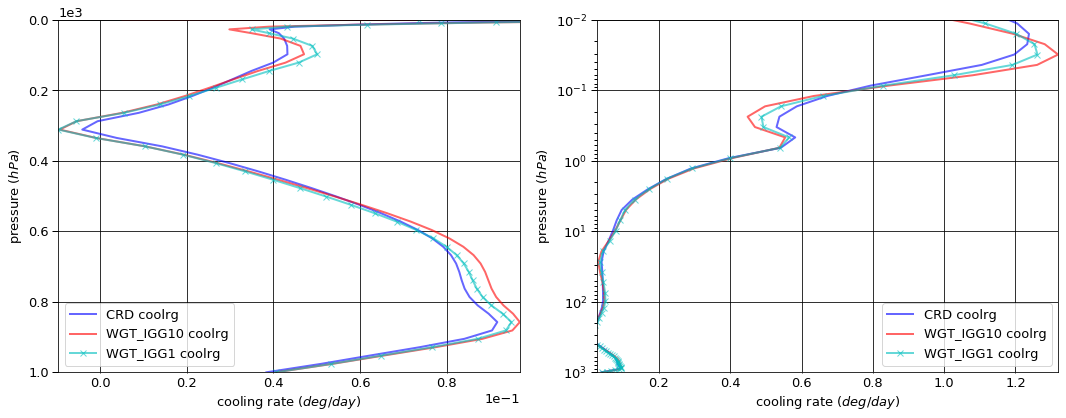

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.013598  0.000000 -0.013598
  1013.0   76    -0.016965  0.017068  0.000103
2 0.0      1     -0.018247  0.000000 -0.018247
  1013.0   76    -0.021240  0.021409  0.000168
3 0.0      1     -0.081665  0.000000 -0.081665
  1013.0   76    -0.126599  0.123040 -0.003559
4 0.0      1     -0.107517  0.000000 -0.107517
  1013.0   76    -0.221960  0.222961  0.001002
5 0.0      1     -0.381840  0.000000 -0.381840
  1013.0   76    -0.754777  0.723545 -0.031232
6 0.0      1     -0.651661  0.000000 -0.651661
  1013.0   76    -1.355339  1.368621  0.013282
7 0.0      1     -3.943098  0.000000 -3.943098
  1013.0   76    -5.679468  5.339259 -0.340209
8 0.0      1     -3.777686  0.000000 -3.777686
  1013.0   76    -4.014662  1.480822 -2.533839
9 0.0      1     -6.695130  0.000000 -6.695130
  1013.0   76    -6.730513  0.341223 -6.389290


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.013380  0.000000 -0.013380
  1013.0   76    -0.017045  0.017147  0.000103
2 0.0      1     -0.018949  0.000000 -0.018949
  1013.0   76    -0.021320  0.021448  0.000128
3 0.0      1     -0.079169  0.000000 -0.079169
  1013.0   76    -0.127004  0.127769  0.000765
4 0.0      1     -0.104471  0.000000 -0.104471
  1013.0   76    -0.222945  0.224286  0.001341
5 0.0      1     -0.332371  0.000000 -0.332371
  1013.0   76    -0.757054  0.763007  0.005953
6 0.0      1     -0.619782  0.000000 -0.619782
  1013.0   76    -1.360243  1.374183  0.013940
7 0.0      1     -3.889078  0.000000 -3.889078
  1013.0   76    -5.696138  5.565651 -0.130487
8 0.0      1     -3.794035  0.000000 -3.794035
  1013.0   76    -4.011631  1.533430 -2.478201
9 0.0      1     -6.677681  0.000000 -6.677681
  1013.0   76    -6.708143  0.308289 -6.399855


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.013415  0.000000 -0.013415
  1013.0   76    -0.017045  0.017147  0.000103
2 0.0      1     -0.018756  0.000000 -0.018756
  1013.0   76    -0.021320  0.021449  0.000129
3 0.0      1     -0.078198  0.000000 -0.078198
  1013.0   76    -0.127004  0.127775  0.000771
4 0.0      1     -0.104377  0.000000 -0.104377
  1013.0   76    -0.222945  0.224287  0.001342
5 0.0      1     -0.333541  0.000000 -0.333541
  1013.0   76    -0.757054  0.763487  0.006433
6 0.0      1     -0.621377  0.000000 -0.621377
  1013.0   76    -1.360243  1.374174  0.013931
7 0.0      1     -3.884178  0.000000 -3.884178
  1013.0   76    -5.696138  5.463320 -0.232818
8 0.0      1     -3.774423  0.000000 -3.774423
  1013.0   76    -4.011631  1.541427 -2.470204
9 0.0      1     -6.674659  0.000000 -6.674659
  1013.0   76    -6.708143  0.329685 -6.378458


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000219  0.000000  2.185710e-04
  1013.0   76    -0.000079  0.000079 -3.668400e-07
2 0.0      1     -0.000702  0.000000 -7.017680e-04
  1013.0   76    -0.000080  0.000040 -4.014713e-05
3 0.0      1      0.002496  0.000000  2.496192e-03
  1013.0   76    -0.000405  0.004729  4.323566e-03
4 0.0      1      0.003047  0.000000  3.046700e-03
  1013.0   76    -0.000985  0.001325  3.395372e-04
5 0.0      1      0.049469  0.000000  4.946908e-02
  1013.0   76    -0.002278  0.039462  3.718477e-02
6 0.0      1      0.031879  0.000000  3.187925e-02
  1013.0   76    -0.004904  0.005562  6.581660e-04
7 0.0      1      0.054020  0.000000  5.402010e-02
  1013.0   76    -0.016670  0.226392  2.097220e-01
8 0.0      1     -0.016349  0.000000 -1.634920e-02
  1013.0   76     0.003031  0.052607  5.563830e-02
9 0.0      1      0.017448  0.000000  1.744830e-02
  1013.0   76     0.022370 -0.032935 -1.056470e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000184  0.000000  1.835440e-04
  1013.0   76    -0.000079  0.000079 -3.668500e-07
2 0.0      1     -0.000510  0.000000 -5.096470e-04
  1013.0   76    -0.000080  0.000040 -3.990855e-05
3 0.0      1      0.003467  0.000000  3.466591e-03
  1013.0   76    -0.000405  0.004735  4.329293e-03
4 0.0      1      0.003141  0.000000  3.140590e-03
  1013.0   76    -0.000985  0.001325  3.398971e-04
5 0.0      1      0.048299  0.000000  4.829868e-02
  1013.0   76    -0.002278  0.039942  3.766472e-02
6 0.0      1      0.030284  0.000000  3.028383e-02
  1013.0   76    -0.004904  0.005553  6.490780e-04
7 0.0      1      0.058920  0.000000  5.892010e-02
  1013.0   76    -0.016670  0.124061  1.073910e-01
8 0.0      1      0.003263  0.000000  3.262900e-03
  1013.0   76     0.003031  0.060605  6.363580e-02
9 0.0      1      0.020471  0.000000  2.047080e-02
  1013.0   76     0.022370 -0.011539  1.083170e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.233712
  1001.112500 75    -0.000016
2 0.000312    1     -0.005950
  1001.112500 75    -0.000022
3 0.000312    1      0.003713
  1001.112500 75    -0.000001
4 0.000312    1      0.000256
  1001.112500 75    -0.000193
5 0.000312    1      0.000782
  1001.112500 75    -0.000073
6 0.000312    1      0.000037
  1001.112500 75    -0.001740
7 0.000312    1      0.000112
  1001.112500 75     0.013949
8 0.000312    1     -0.000021
  1001.112500 75     0.019830
9 0.000312    1     -0.000025
  1001.112500 75     0.006650


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.002853
  1001.112500 75    -0.000016
2 0.000312    1     -0.005532
  1001.112500 75    -0.000020
3 0.000312    1      0.006531
  1001.112500 75    -0.000119
4 0.000312    1      0.000280
  1001.112500 75    -0.000208
5 0.000312    1      0.001016
  1001.112500 75    -0.000958
6 0.000312    1      0.000028
  1001.112500 75    -0.002053
7 0.000312    1      0.000047
  1001.112500 75     0.013698
8 0.000312    1     -0.000027
  1001.112500 75     0.024042
9 0.000312    1     -0.000023
  1001.112500 75     0.006261


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.074055
  1001.112500 75    -0.000016
2 0.000312    1     -0.007028
  1001.112500 75    -0.000020
3 0.000312    1      0.005013
  1001.112500 75    -0.000120
4 0.000312    1      0.000280
  1001.112500 75    -0.000208
5 0.000312    1      0.001173
  1001.112500 75    -0.000992
6 0.000312    1      0.000038
  1001.112500 75    -0.001955
7 0.000312    1      0.000090
  1001.112500 75     0.015088
8 0.000312    1     -0.000022
  1001.112500 75     0.022271
9 0.000312    1     -0.000025
  1001.112500 75     0.006526


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.308585e-01
  1001.112500 75     6.705800e-08
2 0.000312    1      4.179678e-04
  1001.112500 75     1.917616e-06
3 0.000312    1      2.817974e-03
  1001.112500 75    -1.179240e-04
4 0.000312    1      2.451901e-05
  1001.112500 75    -1.557988e-05
5 0.000312    1      2.344286e-04
  1001.112500 75    -8.849358e-04
6 0.000312    1     -8.834593e-06
  1001.112500 75    -3.123431e-04
7 0.000312    1     -6.482604e-05
  1001.112500 75    -2.507110e-04
8 0.000312    1     -5.901004e-06
  1001.112500 75     4.212173e-03
9 0.000312    1      2.453182e-06
  1001.112500 75    -3.891019e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.596566e-01
  1001.112500 75     6.705800e-08
2 0.000312    1     -1.078918e-03
  1001.112500 75     1.867179e-06
3 0.000312    1      1.299896e-03
  1001.112500 75    -1.191678e-04
4 0.000312    1      2.366539e-05
  1001.112500 75    -1.553902e-05
5 0.000312    1      3.907406e-04
  1001.112500 75    -9.186463e-04
6 0.000312    1      8.756890e-07
  1001.112500 75    -2.147013e-04
7 0.000312    1     -2.162580e-05
  1001.112500 75     1.139081e-03
8 0.000312    1     -5.726150e-07
  1001.112500 75     2.440769e-03
9 0.000312    1      8.069240e-07
  1001.112500 75    -1.233235e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.670442,0.000000,-15.670442
1013.0,76,-18.921523,9.637949,-9.283574



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.528915,0.00000,-15.528915
1013.0,76,-18.921523,9.93521,-8.986313



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-15.502925,0.00000,-15.502925
1013.0,76,-18.921523,9.86275,-9.058772



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.415272e-01,0.000000,0.141527
1013.0,76,-7.100000e-08,0.297261,0.297261



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.675174e-01,0.000000,0.167517
1013.0,76,-7.100000e-08,0.224801,0.224801


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.232615
1001.112500,75,0.038383



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.005174
1001.112500,75,0.040626



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.073573
1001.112500,75,0.040573



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.227441
1001.112500,75,0.002244



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.159042
1001.112500,75,0.002190


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000850,0.000901
2,0.001075,0.001127
3,0.006450,0.006712
4,0.011150,0.011783
5,0.038525,0.040010
6,0.068675,0.071889
7,0.290038,0.301040
8,0.213775,0.212014
9,0.369463,0.354524


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310867e-19
2,2.133976e-20
3,1.970626e-21
4,1.774707e-21
5,1.647913e-22
6,5.838237e-22
7,6.101170e-23
8,6.375943e-24
9,2.959058e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310867e-19,NaN,0.000850,0.000901,0.000850,0.000901,1.0
2,2.133976e-20,0.092345,0.001075,0.001127,0.001925,0.002028,1.0
3,1.970626e-21,0.092345,0.006450,0.006712,0.008375,0.008740,1.0
4,1.774707e-21,0.900580,0.011150,0.011783,0.019525,0.020522,10.0
5,1.647913e-22,0.092856,0.038525,0.040010,0.058050,0.060533,10.0
6,5.838237e-22,3.542806,0.068675,0.071889,0.126725,0.132421,500.0
7,6.101170e-23,0.104504,0.290038,0.301040,0.416763,0.433461,500.0
8,6.375943e-24,0.104504,0.213775,0.212014,0.630537,0.645476,500.0
9,2.959058e-25,0.046410,0.369463,0.354524,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
